In [1]:
import pandas as pd
import wget
import os
import lmfit
from lmfit.models import StepModel, ExponentialModel, PolynomialModel


DataSource = 'OurWorldData'

if DataSource == 'JohnHopkins':
    fname = 'time_series_19-covid-Confirmed.csv'

    if os.path.exists(fname):
        os.remove(fname)

    ddir = 'data/'
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
    ff = wget.download(url)
    print (ff)
    assert ff == fname, f'File name retrieved {ff} changed name? {fname}'

    dd = pd.read_csv(ff)

else:
    fname = 'full_data.csv'
    if os.path.exists(fname):
        os.remove(fname)
    
    url = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
    ff = wget.download(url)
    assert ff == fname, f'File name retrieved {ff} changed name? {fname}'
    dd = pd.read_csv(ff, parse_dates = ['date'])
    
    
## Data source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series



In [2]:
dd['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Faeroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar',
       'Greece', 'Greenland', 'Grena

In [3]:
dd

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2019-12-31,Afghanistan,0,0,0,0
1,2020-01-01,Afghanistan,0,0,0,0
2,2020-01-02,Afghanistan,0,0,0,0
3,2020-01-03,Afghanistan,0,0,0,0
4,2020-01-04,Afghanistan,0,0,0,0
...,...,...,...,...,...,...
6631,2020-03-24,Zambia,0,0,3,0
6632,2020-03-21,Zimbabwe,1,0,1,0
6633,2020-03-22,Zimbabwe,1,0,2,0
6634,2020-03-23,Zimbabwe,0,0,2,0


           date     location  new_cases  new_deaths  total_cases  total_deaths
4345 2019-12-31  New Zealand          0           0            0             0
4346 2020-01-01  New Zealand          0           0            0             0
4347 2020-01-02  New Zealand          0           0            0             0
4348 2020-01-03  New Zealand          0           0            0             0
4349 2020-01-04  New Zealand          0           0            0             0
...         ...          ...        ...         ...          ...           ...
4416 2020-03-20  New Zealand         11           0           39             0
4417 2020-03-21  New Zealand         14           0           53             0
4418 2020-03-22  New Zealand         13           0           66             0
4419 2020-03-23  New Zealand         36           0          102             0
4420 2020-03-24  New Zealand         40           0          142             0

[76 rows x 6 columns]
2020-03-02 00:00:00 62
New Ze

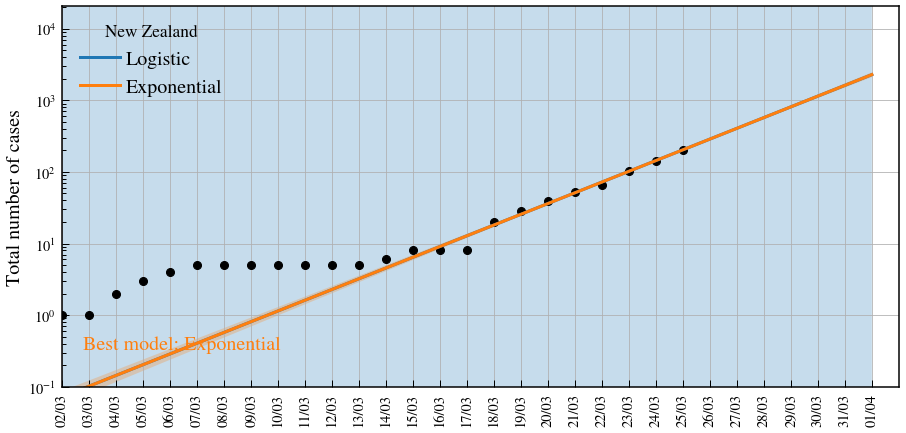

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

countries = ['New Zealand']#,'Italy','Spain']
ncountries = len(countries)
models= {'Logistic': StepModel(form='logistic'), 
        'Exponential': ExponentialModel() }#,
        #'3rd deg. Polynomial': PolynomialModel(degree=3)}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
fig, axs = plt.subplots(ncountries,figsize=(15,ncountries*7))
plt.rcParams['legend.title_fontsize'] = 'xx-large'

countryvar = 'location' if DataSource == 'OurWorldData' else 'Country/Region'

covid_dict = {}

for icc,country in enumerate(countries):

    sel = dd[countryvar] == country
    dc = dd.loc[sel]
    print (dc)
    cols = list(dc.columns)
    dates = cols[4:] if DataSource == 'JohnHopkins' else dc['date'].reset_index(drop=True)

    if DataSource == 'JohnHopkins':
        nn = []
        for i in dates:
            nn.append(dc[i].to_numpy()[0])
    else:
        nn      = dc['total_cases'].reset_index(drop=True).to_numpy()
        ndeaths = dc['total_deaths'].reset_index(drop=True).to_numpy()
        nnew    = dc['new_cases'].reset_index(drop=True).to_numpy()
        
    xstart = 0
    
    for ii, inn in enumerate(list(nn)):
        if inn > 1:
            xstart = ii-1 if ii > 1 else 0
            break
#    import pdb ; pdb.set_trace()        
    nn = nn[xstart:]
    if DataSource != 'JohnHopkins':
        ndeaths  = ndeaths[xstart:]
        nnew     = nnew[xstart:]
        
    print (dates.iloc[xstart], xstart)
    dates = dates.iloc[xstart:].reset_index(drop=True)
    
    # ensuring data completeness    
    dates_all = pd.date_range(start=dates.iloc[0], end=dates.iloc[-1])
    ntotal      = [] #np.zeros(len(dates_all))
    ntot_deaths = []
    ntot_new    = []
    
    
    iid = 0
    for ixx, idate in enumerate(dates_all):
        if dates.iloc[iid] == idate:
            ntotal.append(nn[iid])
            ntot_deaths.append(ndeaths[iid])
            ntot_new.append(nnew[iid])
            iid += 1
        else:
            ntotal.append(ntotal[ixx-1])
            ntot_deaths.append(ntot_deaths[ixx-1])
            ntot_new.append(ntot_new[ixx-1])
            
    
    #import pdb ; pdb.set_trace()
    add_data_manually = True  # to add latest info not in the database yet
    
    if add_data_manually:
        if country == 'Chile':
            ntotal.append(746)
            ntot_deaths.append(ntot_deaths[-1])
            ntot_new.append(ntotal[-1] - ntotal[-2])
            dates_all = pd.date_range(start=dates.iloc[0], periods = len(dates_all)+1)
        if country == 'New Zealand':
            ntotal.append(205)
            ntot_deaths.append(0)
            ntot_new.append(ntotal[-1] - ntotal[-2])
            dates_all = pd.date_range(start=dates.iloc[0], periods = len(dates_all)+1)
    
    nn = ntotal
    dates = dates_all
    xstart = 0
    
    covid_dict[country] = {'dates': dates,
                         'ntotal': ntotal,
                         'ntot_deaths': ntot_deaths,
                          'ntot_new':ntot_new
                         }
    
    print (country, xstart)
    ndata = len(nn)
    nn = np.array(nn)
    xx = np.arange(0,ndata)
    xxx = np.arange(0,ndata+7)
    nper = len(xxx)
    print (country, nper)
    xxxx = np.arange(0,ndata+7)# if nper < 100 else 2)
    datesxxx = pd.date_range(start=dates[0], periods=nper).strftime('%d/%m')
    
    #import pdb ; pdb.set_trace()    
    
    print (datesxxx)
    
    if ncountries > 1:
        ax = axs[icc]
    else:
        ax = axs

    
    ax.set_xticks(xxxx)
    ax.set_xticklabels(datesxxx[xxxx], rotation='vertical')
    ax.plot(xx,nn,'ko',markersize=8)
    ax.set_yscale('log')

    icol = 0 
    ixx = np.where(nn > 10)[0] if country == 'Spain' else np.where(nn > 8)[0]
    bics = []
    mn = []
    
    for mname, model in models.items():
       
        pars0 = model.guess(nn[ixx], x=xx[ixx])
        out = model.fit(nn[ixx], pars0, x=xx[ixx])
        pars = out.params
        bics.append(out.bic)
        mn.append(mname)
 
        dely = out.eval_uncertainty(x=xxx)
        y =  out.eval(pars,x=xxx)        
        ax.plot(xxx,y, '-', label=f'{mname}', color=colors[icol],linewidth=3)
        ax.fill_between(xxx, y-dely,y+dely,facecolor=colors[icol],alpha=0.25)
        icol += 1
        
       # print (mname, country, y[len(xx) + 11], bics[-1])
    
    bic = np.argmin(bics)
    ax.text(0.025,0.1,f'Best model: {mn[bic]}', fontsize=20,
           transform=ax.transAxes, color= colors[bic])


    ax.set_xlim([0,ndata + 7])
    ax.set_ylim([0.1,np.min([100000, np.max(nn)*100])])
    #ax.ticklabel_format(axis='y', style='sci',useMathText=True, scilimits=(0,5))
    ax.set_ylabel('Total number of cases',fontsize=20)
    ax.legend(title=country, fontsize=20,loc='upper left')
    ax.grid()
    

plt.show()


#popt2, pcov2 = curve_fit(sigmoid, np.arange(ndata), nn, sigma= err,p0=[.001, .1,.1],absolute_sigma=True)


#print (popt)

In [5]:
def figures_to_html(figs, filename="test2.html"):
    dashboard = open(filename, 'w')
    dashboard.write("<html><head><style>div {display: inline-block;}</style></head><body>" + "\n")
    for fig in figs:
        inner_html = fig.to_html(auto_play=False).split('<body>')[1].split('</body>')[0]
        dashboard.write(inner_html)
    dashboard.write("</body></html>" + "\n")

In [6]:
import plotly.graph_objects as go

animated_plot = True
allfigs = []

if animated_plot:

    for country, cdict in covid_dict.items():
    
        _yname = ['ntotal']
        _xname = ['dates']
        df = pd.DataFrame(cdict)

        for xname, yname in zip(_xname, _yname):

            colorvar = 'ntot_deaths'
            size  = 'ntot_new'
            temp  = 'dates'
            
            #weeks = list(np.arange(df[temp].iloc[0], df[temp].iloc[-1]))
            weeks = df[temp].dt.strftime('%m/%d')

            # make list of continents
            colorprops = df[colorvar].unique()

            # make figure
            fig_dict = {
                "data": [],
                "layout": {},
                "frames": []
            }


            minx, maxx = df[xname].min(), df[xname].max()
            miny, maxy = df[yname].min(), df[yname].max()


            # fill in most of layout
            fig_dict["layout"]["xaxis"] = {"range": [minx,maxx], "title": xname}
            fig_dict["layout"]["yaxis"] = {"title": yname, "range": [miny,maxy]}
            fig_dict["layout"]["hovermode"] = "closest"
            fig_dict["layout"]["sliders"] = {
                "args": [
                    "transition", {
                        "duration": 400,
                        "easing": "cubic-in-out"
                    }
                ],
                "initialValue": weeks[0],
                "plotlycommand": "animate",
                "values": weeks,
                "visible": True
            }
            fig_dict["layout"]["updatemenus"] = [
                {
                    "buttons": [
                        {
                            "args": [None, {"frame": {"duration": 500, "redraw": False},
                                            "fromcurrent": True, "transition": {"duration": 300,
                                                                                "easing": "quadratic-in-out"}}],
                            "label": "Play",
                            "method": "animate"
                        },
                        {
                            "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                              "mode": "immediate",
                                              "transition": {"duration": 0}}],
                            "label": "Pause",
                            "method": "animate"
                        }
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 87},
                    "showactive": False,
                    "type": "buttons",
                    "x": 0.1,
                    "xanchor": "right",
                    "y": 0,
                    "yanchor": "top"
                }
            ]

            sliders_dict = {
                "active": 0,
                "yanchor": "top",
                "xanchor": "left",
                "currentvalue": {
                    "font": {"size": 20},
                    "prefix": temp+":",
                    "visible": True,
                    "xanchor": "right"
                },
                "transition": {"duration": 300, "easing": "cubic-in-out"},
                "pad": {"b": 10, "t": 50},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": []
            }

            # make data
            for color in colorprops:
                df_color  = df.loc[(df[colorvar] == color) & (df[temp] == df[temp][0])]

                data_dict = {
                    "x": list(df_color[xname]),
                    "y": list(df_color[yname]),
                    "mode": "markers",
                    "text":  [f'{size}: {x-1}' for x in df_color[size]],
                    "marker": {
                        "sizemode": "area",
                        "sizeref": 0.1,
                        "size": list(df_color[size])
                    },
                    "name": color
                            }
                fig_dict["data"].append(data_dict)

            # make frames
            for week in weeks:
                frame = {"data": [], "name": week}
                for color in colorprops:
                    df_color  = df.loc[(df[colorvar] == color) & (df[temp] == df[temp][0])]
                    data_dict = {
                    "x": list(df_color[xname]),
                    "y": list(df_color[yname]),
                    "mode": "markers",
                    "text": [f'{size}: {x-1}' for x in df_color[size]],
                    "marker": {
                    "sizemode": "area",
                    "sizeref": 0.1,
                    "size": list(df_color[size])
                    },
                    "name": color
                    }
                    frame["data"].append(data_dict)

                fig_dict["frames"].append(frame)
                slider_step = {"args": [
                    [week],
                    {"frame": {"duration": 300, "redraw": False},
                     "mode": "immediate",
                     "transition": {"duration": 300}}
                ],
                    "label": week,
                    "method": "animate"}
                sliders_dict["steps"].append(slider_step)


            fig_dict["layout"]["sliders"] = [sliders_dict]

            fig = go.Figure(fig_dict)
            fig.update_layout(height=600, width=900)
            allfigs.append(fig)
    #fig.write_html('test.html', auto_open=True)
figures_to_html(allfigs, filename = 'animation.html')


ValueError: 
    Invalid value of type 'numpy.int64' received for the 'name' property of scatter
        Received value: 0

    The 'name' property is a string and must be specified as:
      - A string
      - A number that will be converted to a string

In [ ]:
%debug

In [ ]:

d


